<b> Objective: Build a character-level RNN that, when given a family name, can predict the language of origin of that name. </b>

In [1]:
import io
import glob
import os

In [2]:
import unicodedata
import string

In [3]:
import torch
import random

In [4]:
# String of all letters in English Alphabet + additional characters
all_letters = string.ascii_letters + " .,;'" #Extra punctuation marks allow the model to handle real-world uncleaned data that might contain some noise
n_letters = len(all_letters) #57

In [5]:
print(all_letters)

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'


In [6]:
# Convert a Unicode string to plain ASCII (removing non-ASCII characters or diacritical marks (accents))
# Reference - https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s) # Normalization Form Decomposition
        if unicodedata.category(c) != 'Mn' # Mark, Non-Spacing
        and c in all_letters
    )

In [7]:
print(unicodeToAscii('Ślusàrski'))
print(unicodeToAscii('Jalapeño'))
print(unicodeToAscii('Au-Yong'))

Slusarski
Jalapeno
AuYong


In [8]:
def load_data():
    # Build the category_lines dictionary, a list of names per language
    category_lines = {}
    all_categories = []

    # Function to find files from a path
    def find_files(path):
        return glob.glob(path)
    
    # Read a file and split into lines, converts every line from Unicode to ASCII
    def read_lines(filename):
        lines = io.open(filename, encoding='utf-8').read().strip().split('\n')
        return [unicodeToAscii(line) for line in lines]
    
    # Creates a dictionary category lines = {'Category': ['Line1', 'Line2',...]}
    # category lines = {'Arabic': ['Khoury', 'Naher',...], 'Chinese': ['Ang', 'AuYong',...], ...}
    for filename in find_files('names/*.txt'):
        category = os.path.splitext(os.path.basename(filename))[0]
        all_categories.append(category) # all_categories = ['Arabic', 'Chinese', ..., 'Vietnamese']
        lines = read_lines(filename)
        category_lines[category] = lines
        
    return category_lines, all_categories

In [9]:
category_lines_example, all_categories_example = load_data()
print(category_lines_example['French'][:10])   

['Abel', 'Abraham', 'Adam', 'Albert', 'Allard', 'Archambault', 'Armistead', 'Arthur', 'Augustin', 'Babineaux']


<b><p> To represent a single letter, we use a “one-hot vector” of size <1 x n_letters></p></b> 
<b><p> A one-hot vector is filled with 0s except for a 1 at index of the current letter, e.g. "b" = <0 1 0 0 0 ...></p></b>
<b><p> To make a word we join a bunch of those into a 2D matrix <line_length x 1 x n_letters>, e.g. "adam" : <4 X 1 X 57> matrix</p></b>
<b><p> “a” = ( 1 0 0 0 . . . ) 
<b><p> “d” = ( 0 0 0 1 . . . )</p></b>
<b><p> “a” = ( 1 0 0 0 . . . )</p></b>
<b><p> “m” = ( 0 0 0 0 . . 1.. )
<b><p> That extra 1 dimension is because PyTorch assumes everything is in batches - we’re just using a batch size of 1 here</p></b>
>

In [10]:
# Find letter index from all_letters, e.g. "a" = 0
def letter_to_index(letter):
    return all_letters.find(letter)

In [11]:
# Turn a letter into a <1 X n_letters> tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

In [12]:
print(letter_to_tensor('N'))
print(letter_to_tensor('N').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([1, 57])


In [13]:
# Turn a line into a <line_length x 1 x n_letters>, # or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for i, letter in enumerate(line):
        tensor[i][0][letter_to_index(letter)] = 1
    return tensor

In [14]:
print(line_to_tensor('Casey'))
print(line_to_tensor('Casey').size())

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

In [15]:
# To create a random training example
def random_training_example(category_lines, all_categories):
    
    def random_choice(a):
        random_idx = random.randint(0, len(a) - 1)
        return a[random_idx]
    
    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor

In [38]:
random_training_example(category_lines_example, all_categories_example)

('Italian',
 'Traversa',
 tensor([9]),
 tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.]],
 
         [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,

<b> Creating the Network

Building a RNN with just 3 linear layers which operate on an input and hidden state, with a Logsoftmax layer after the output </b>

In [17]:
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [18]:
class RNN(nn.Module):
    # implement RNN from scratch rather than using nn.RNN
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size) #Transforms the combined input and hidden state into a new hidden state
        self.i2o = nn.Linear(input_size + hidden_size, output_size) #Transforms the combined input and hidden state into an output
        self.softmax = nn.LogSoftmax(dim=1) #Converts the output into probabilities

    #Forward Pass - Combines the input and hidden state, updates the hidden state, and computes the output at each timestep
    def forward(self, input_tensor, hidden_tensor):
        combined = torch.cat((input_tensor, hidden_tensor), 1)
        
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self): #Initialize hidden state
        return torch.zeros(1, self.hidden_size)

In [19]:
category_lines, all_categories = load_data()
n_categories = len(all_categories) #18
n_hidden = 128

In [20]:
rnn = RNN(n_letters, n_hidden, n_categories)

In [21]:
# Whole Sequence/Name
input_tensor = line_to_tensor('Albert')
hidden_tensor = rnn.init_hidden()

output, next_hidden = rnn(input_tensor[0], hidden_tensor)

print(output.size())
print(next_hidden.size())

torch.Size([1, 18])
torch.Size([1, 128])


In [22]:
output

tensor([[-2.9739, -2.8700, -2.8429, -2.9285, -2.8550, -2.9434, -2.7881, -2.8951,
         -2.9516, -2.8644, -2.9142, -2.8415, -2.8828, -2.9464, -2.8724, -2.8883,
         -2.9469, -2.8424]], grad_fn=<LogSoftmaxBackward0>)

In [23]:
# Combine categories with their corresponding scores
output_1d = output.squeeze()
category_scores = list(zip(all_categories, output_1d.tolist()))

# Print the result
for category, score in category_scores:
    print(f"{category}: {score:.4f}")

Arabic: -2.9739
Chinese: -2.8700
Czech: -2.8429
Dutch: -2.9285
English: -2.8550
French: -2.9434
German: -2.7881
Greek: -2.8951
Irish: -2.9516
Italian: -2.8644
Japanese: -2.9142
Korean: -2.8415
Polish: -2.8828
Portuguese: -2.9464
Russian: -2.8724
Scottish: -2.8883
Spanish: -2.9469
Vietnamese: -2.8424


In [24]:
def category_from_output(output):
    category_idx = torch.argmax(output).item()
    return all_categories[category_idx]

In [25]:
print(category_from_output(output))

German


<b> Training the Network </b>

To train this network we show it a bunch of examples, have it make guesses, and tell it if it’s wrong.

<b> Each loop of training will:

Create input and target tensors

Create a zeroed initial hidden state

Read each letter in and

Keep hidden state for next letter

Compare final output to target

Back-propagate

Return the output and loss

In [26]:
# Loss Function
criterion = nn.NLLLoss()

In [27]:
# Learning Rate
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

In [28]:
# Setting up the optimizer for training RNN using the Stochastic Gradient Descent (SGD) algorithm
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

In [29]:
def train(line_tensor, category_tensor):
    hidden = rnn.init_hidden()

    # Forward pass through each timestep - Processes each character in a sequence
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    loss = criterion(output, category_tensor)

    # Perform backpropagation to update the model parameters based on the computed loss
    optimizer.zero_grad() # Clears the gradients of all optimized tensors. PyTorch accumulates gradients by default, so you need to zero them before each backward pass
    loss.backward() # Computes the gradients of the loss with respect to each parameter of the model using backpropagation
    optimizer.step() # Updates the model parameters using the gradients computed by loss.backward()
    
    return output, loss.item()

In [30]:
current_loss = 0
all_losses = []
plot_steps, print_steps = 1000, 5000
n_iters = 100000

In [31]:
#Training Loop for the RNN model
for i in range(n_iters):
    category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories)
    
    output, loss = train(line_tensor, category_tensor)
    current_loss += loss 
    
    if (i+1) % plot_steps == 0:
        all_losses.append(current_loss / plot_steps)
        current_loss = 0
        
    if (i+1) % print_steps == 0:
        guess = category_from_output(output)
        correct = "CORRECT" if guess == category else f"WRONG ({category})"
        print(f"{i+1} {(i+1)/n_iters*100}% {loss:.4f} {line} / {guess} {correct}")

5000 5.0% 2.5208 Coilean / Scottish WRONG (Irish)
10000 10.0% 2.0572 Leizerman / Dutch WRONG (Russian)
15000 15.0% 0.6653 Iwahara / Japanese CORRECT
20000 20.0% 1.4408 Gaber / Arabic CORRECT
25000 25.0% 1.2956 Jian / Chinese CORRECT
30000 30.0% 1.9067 Blaise / Arabic WRONG (French)
35000 35.0% 1.5376 Janvier / French CORRECT
40000 40.0% 0.0627 Nishihara / Japanese CORRECT
45000 45.0% 0.7787 Magalhaes / Portuguese CORRECT
50000 50.0% 2.3424 Baba / Japanese WRONG (Arabic)
55000 55.00000000000001% 2.6152 Santana / Spanish WRONG (Portuguese)
60000 60.0% 2.3881 Aleshite / French WRONG (German)
65000 65.0% 0.4012 Puerta / Spanish CORRECT
70000 70.0% 0.6808 Worner / German CORRECT
75000 75.0% 0.1626 Napoleoni / Italian CORRECT
80000 80.0% 4.7237 Names / Arabic WRONG (Irish)
85000 85.0% 0.5126 Zhelezko / Russian CORRECT
90000 90.0% 0.1706 Zeng / Chinese CORRECT
95000 95.0% 4.0657 Guerra / Portuguese WRONG (Italian)
100000 100.0% 0.4358 Jackson / Scottish CORRECT


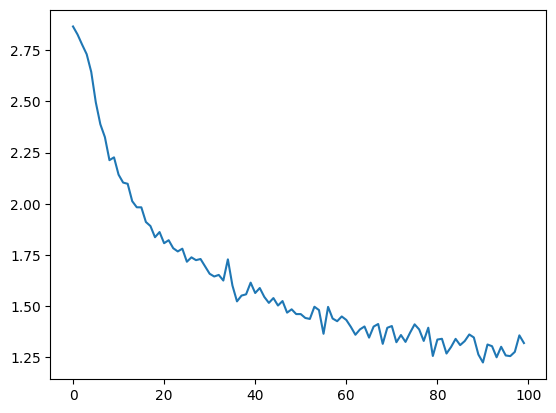

In [33]:
plt.figure()
plt.plot(all_losses)
plt.show()

<b> Evaluating the Results </b>

To see how well the network performs on different categories, we will create a confusion matrix, indicating for every actual language (rows) which language the network guesses (columns). To calculate the confusion matrix a bunch of samples are run through the network with evaluate(), which is the same as train() minus the backprop.

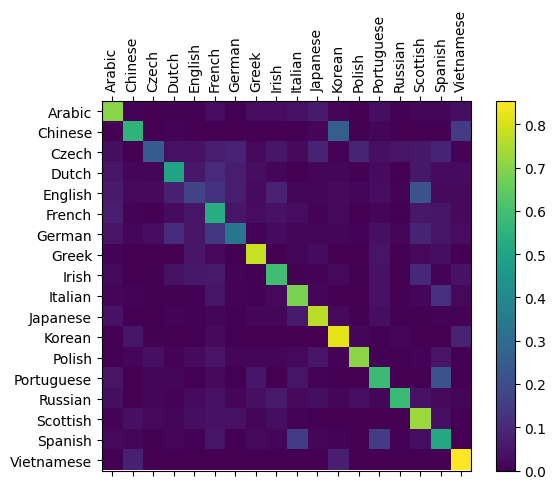

In [35]:
#Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)  # n_categories should be the number of language categories
n_confusion = 10000  # Number of examples to evaluate

# Function to evaluate a line and get the output from the model
def evaluate(line_tensor):
    hidden = rnn.init_hidden()  # Initialize hidden state
    for i in range(line_tensor.size()[0]):  # Loop through the line's characters
        output, hidden = rnn(line_tensor[i], hidden)  # Get output from the RNN
    return output  # Return the output (logits for categories)

# Loop to populate the confusion matrix
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories)
    output = evaluate(line_tensor)  # Get the model's output for the input
    guess_i = all_categories.index(category_from_output(output))  # Predicted category index
    category_i = all_categories.index(category)  # Actual category index
    confusion[category_i, guess_i] += 1  # Use comma to index a 2D tensor properly

# Normalize the confusion matrix row-wise
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()  # Normalize by the sum of each row

# Plotting the confusion matrix as a heat map
fig, ax = plt.subplots()
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)  # Add color bar

# Set up axis labels
ax.set_xticks(range(n_categories))
ax.set_yticks(range(n_categories))
ax.set_xticklabels(all_categories, rotation=90)  # Rotate category labels for readability
ax.set_yticklabels(all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

<b> Testing the model on unseen data </b>

In [36]:
def predict(input_line):
    print(f"\n> {input_line}")
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line)
        
        hidden = rnn.init_hidden()
    
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)
        
        guess = category_from_output(output)
        print(f"\n{guess}")

In [37]:
while True:
    sentence = input("Input:")
    if sentence == "quit":
        break
    
    predict(sentence)

Input: Zimmer



> Zimmer

German


Input: Vlad



> Vlad

English


Input: Chen



> Chen

Korean


Input: Beckham



> Beckham

Arabic


Input: Bukowski



> Bukowski

Polish


Input: Asghar



> Asghar

Arabic


Input: Chang



> Chang

Korean


Input: quit
